In [142]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import operator, itertools

from scipy import stats

pd.options.display.max_columns = None

In [175]:
train_X = pd.read_csv('../input/lish-moa/train_features.csv', index_col='sig_id')
test_Y = pd.read_csv('../input/lish-moa/sample_submission.csv', index_col='sig_id')
train_Y = pd.read_csv('../input/lish-moa/train_targets_scored.csv', index_col='sig_id', dtype={f: test_Y.dtypes[f] for f in test_Y})
test_X = pd.read_csv('../input/lish-moa/test_features.csv', index_col='sig_id')

In [176]:
train_X.cp_time = train_X.cp_time / 24
test_X.cp_time = test_X.cp_time / 24

train_X['real_drug'] = train_X.cp_type == 'trt_cp'

t = train_X.cp_dose.copy()
train_X.drop(columns=['cp_dose'], inplace=True)
train_X['cp_dose'] = 1
train_X.loc[(t == 'D2'), 'cp_dose'] = 2

t = test_X.cp_dose.copy()
test_X.drop(columns=['cp_dose'], inplace=True)
test_X['cp_dose'] = 1
test_X.loc[(t == 'D2'), 'cp_dose'] = 2

In [177]:
features = list(train_X.columns)
features_g = [col for col in train_X.columns if 'g-' in col]
features_c = [col for col in train_X.columns if 'c-' in col]
features_gc = features_g + features_c
targets = list(train_Y.columns)

In [178]:
train_X

cp_type  cp_time     g-0     g-1     g-2     g-3     g-4  \
sig_id                                                                       
id_000644bb2       trt_cp      1.0  1.0620  0.5577 -0.2479 -0.6208 -0.1944   
id_000779bfc       trt_cp      3.0  0.0743  0.4087  0.2991  0.0604  1.0190   
id_000a6266a       trt_cp      2.0  0.6280  0.5817  1.5540 -0.0764 -0.0323   
id_0015fd391       trt_cp      2.0 -0.5138 -0.2491 -0.2656  0.5288  4.0620   
id_001626bd3       trt_cp      3.0 -0.3254 -0.4009  0.9700  0.6919  1.4180   
...                   ...      ...     ...     ...     ...     ...     ...   
id_fffb1ceed       trt_cp      1.0  0.1394 -0.0636 -0.1112 -0.5080 -0.4713   
id_fffb70c0c       trt_cp      1.0 -1.3260  0.3478 -0.3743  0.9905 -0.7178   
id_fffc1c3f4  ctl_vehicle      2.0  0.3942  0.3756  0.3109 -0.7389  0.5505   
id_fffcb9e7c       trt_cp      1.0  0.6660  0.2324  0.4392  0.2044  0.8531   
id_ffffdd77b       trt_cp      3.0 -0.8598  1.0240 -0.1361  0.7952 -0.3611   

                 g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
sig_id                                                                         
id_000644bb2 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
id_000779bfc  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
id_000a6266a  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
id_0015fd391 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
id_001626bd3 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed  0.7201  0.5773  0.3055 -0.4726  0.1269  0.2531  0.1730 -0.4532   
id_fffb70c0c  0.6621 -0.2252 -0.5565  0.5112  0.6727 -0.1851  2.8650 -0.2140   
id_fffc1c3f4 -0.0159 -0.2541  0.1745 -0.0340  0.4865 -0.1854  0.0716  0.1729   
id_fffcb9e7c -0.0343  0.0323  0.0463  0.4299 -0.7985  0.5742  0.1421  2.2700   
id_ffffdd77b -3.6750 -1.2420  0.9146  3.0790  1.2460  1.9460  1.4370  2.9780   

                g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20  \
sig_id                                                                         
id_000644bb2 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688   
id_000779bfc  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449   
id_000a6266a -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799   
id_0015fd391 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200   
id_001626bd3  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed -1.0790  0.2474 -0.4550  0.3588  0.1600 -0.7362 -0.1103  0.8550   
id_fffb70c0c -0.6153  0.8362  0.5584 -0.2589  0.1292  0.0148  0.0949 -0.2182   
id_fffc1c3f4 -0.0434  0.1542 -0.2192 -0.0302 -0.4218  0.4057 -0.5372  0.1521   
id_fffcb9e7c  0.2046  0.5363 -1.7330  0.1450  0.6097  0.2024  0.9865 -0.7805   
id_ffffdd77b  2.2370 -0.6818  0.6870 -1.1060  0.0182 -0.9247 -0.0738 -0.1919   

                g-21    g-22    g-23    g-24    g-25    g-26    g-27    g-28  \
sig_id                                                                         
id_000644bb2 -1.1360 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853   
id_000779bfc -0.1646 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216   
id_000a6266a -0.8181 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437   
id_0015fd391 -1.1580 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479   
id_001626bd3 -0.2685  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed -0.4139  0.5541  0.2310 -0.5573 -0.4397 -0.9260 -0.2424 -0.6686   
id_fffb70c0c -0.9235  0.0749 -1.5910 -0.8359 -0.9217  0.3013  0.1716  0.0880   
id_fffc1c3f4 -0.2651  0.2310 -0.8101  0.4943  0.6905 -0.3720 -1.4110  0.4516   
id_fffcb9e7c  0.9608  0.3440  2.7650  0.4

In [179]:
train_Y

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
sig_id                                                              
id_000644bb2                          0.0                     0.0   
id_000779bfc                          0.0                     0.0   
id_000a6266a                          0.0                     0.0   
id_0015fd391                          0.0                     0.0   
id_001626bd3                          0.0                     0.0   
...                                   ...                     ...   
id_fffb1ceed                          0.0                     0.0   
id_fffb70c0c                          0.0                     0.0   
id_fffc1c3f4                          0.0                     0.0   
id_fffcb9e7c                          0.0                     0.0   
id_ffffdd77b                          0.0                     0.0   

              acat_inhibitor  acetylcholine_receptor_agonist  \
sig_id                                                         
id_000644bb2             0.0                             0.0   
id_000779bfc             0.0                             0.0   
id_000a6266a             0.0                             0.0   
id_0015fd391             0.0                             0.0   
id_001626bd3             0.0                             0.0   
...                      ...                             ...   
id_fffb1ceed             0.0                             0.0   
id_fffb70c0c             0.0                             0.0   
id_fffc1c3f4             0.0                             0.0   
id_fffcb9e7c             0.0                             0.0   
id_ffffdd77b             0.0                             0.0   

              acetylcholine_receptor_antagonist  \
sig_id                                            
id_000644bb2                                0.0   
id_000779bfc                                0.0   
id_000a6266a                                0.0   
id_0015fd391                                0.0   
id_001626bd3                                0.0   
...                                         ...   
id_fffb1ceed                                0.0   
id_fffb70c0c                                0.0   
id_fffc1c3f4                                0.0   
id_fffcb9e7c                                0.0   
id_ffffdd77b                                0.0   

              acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
sig_id                                                                     
id_000644bb2                             0.0                         0.0   
id_000779bfc                             0.0                         0.0   
id_000a6266a                             0.0                         0.0   
id_0015fd391                             0.0                         0.0   
id_001626bd3                             0.0                         0.0   
...                                      ...                         ...   
id_fffb1ceed                             0.0                         0.0   
id_fffb70c0c                             0.0                         0.0   
id_fffc1c3f4                             0.0                         0.0   
id_fffcb9e7c                             0.0                         0.0   
id_ffffdd77b                             0.0                         0.0   

              adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
sig_id                                                                    
id_000644bb2                            0.0                         0.0   
id_000779bfc                            0.0                         0.0   
id_000a6266a                            0.0                         0.0   
id_0015fd391                            0.0                         0.0   
id_001626bd3                            0.0                         0.0   
...                                     ...                         ...   
id_fffb1ceed                  

In [180]:
test_X

cp_type  cp_time     g-0     g-1     g-2     g-3     g-4  \
sig_id                                                                       
id_0004d9e33       trt_cp      1.0 -0.5458  0.1306 -0.5135  0.4408  1.5500   
id_001897cda       trt_cp      3.0 -0.1829  0.2320  1.2080 -0.4522 -0.3652   
id_002429b5b  ctl_vehicle      1.0  0.1852 -0.1404 -0.3911  0.1310 -1.4380   
id_00276f245       trt_cp      1.0  0.4828  0.1955  0.3825  0.4244 -0.5855   
id_0027f1083       trt_cp      2.0 -0.3979 -1.2680  1.9130  0.2057 -0.5864   
...                   ...      ...     ...     ...     ...     ...     ...   
id_ff7004b87       trt_cp      1.0  0.4571 -0.5743  3.3930 -0.6202  0.8557   
id_ff925dd0d       trt_cp      1.0 -0.5885 -0.2548  2.5850  0.3456  0.4401   
id_ffb710450       trt_cp      3.0 -0.3985 -0.1554  0.2677 -0.6813  0.0152   
id_ffbb869f2       trt_cp      2.0 -1.0960 -1.7750 -0.3977  1.0160 -1.3350   
id_ffd5800b6       trt_cp      3.0 -0.5174  0.2953  0.3286 -0.0428 -0.0800   

                 g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
sig_id                                                                         
id_0004d9e33 -0.1644 -0.2140  0.2221 -0.3260  1.9390 -0.2305 -0.3670  1.3040   
id_001897cda -0.3319 -1.8820  0.4022 -0.3528  0.1271  0.9303  0.3173 -1.0120   
id_002429b5b  0.2455 -0.3390 -0.3206  0.6944  0.5837 -0.0553 -0.6222  2.5430   
id_00276f245 -1.2020  0.5998 -0.1799  0.9365  0.2942  1.3990 -1.1080  1.1610   
id_0027f1083 -0.0166  0.5128  0.6365  0.2611 -1.1120 -0.1747 -0.2053 -0.0006   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_ff7004b87  1.6240  0.0640 -0.6316 -1.1990  0.7312  0.2752  0.8771  0.7721   
id_ff925dd0d  0.3107 -0.7437 -0.0143  0.2615  1.9980  0.2010  0.3961  0.8776   
id_ffb710450  0.4791 -0.0166  0.7501  0.0346  1.3910  0.4557 -0.4277 -0.1186   
id_ffbb869f2 -0.2207 -0.3611 -1.3020  1.0150  0.6747  1.5290  0.6784  1.2500   
id_ffd5800b6  0.8702 -0.8724  0.3883 -0.0491  0.3557  0.2370  0.2471 -0.1459   

                g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20  \
sig_id                                                                         
id_0004d9e33  1.4610  0.0043  0.6816 -0.2304 -0.0635 -0.2030 -0.6821 -0.6242   
id_001897cda -0.3213  0.0607 -0.5389 -0.8030 -1.0600 -0.0978 -0.8156 -0.6514   
id_002429b5b -0.7857  0.8163 -0.0495  0.1806  1.0290 -0.5204 -1.1070  0.7365   
id_00276f245 -0.8134  0.0743 -0.3096 -0.9956  1.7100  1.2200 -0.1258 -0.5900   
id_0027f1083  0.0254  0.1784 -0.1314  1.0700  0.0477 -0.0756  0.1287  0.1403   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_ff7004b87 -0.6836 -0.7374 -1.1620  0.1262  0.2718  0.3968 -1.1580  0.9891   
id_ff925dd0d -0.9688  0.1743  1.4400  1.6480 -0.1872  0.3744  0.5423  0.6170   
id_ffb710450 -0.2801  0.4377 -0.7897 -0.1892  0.9756  0.4994 -0.9567 -1.2720   
id_ffbb869f2  1.3950  1.0250  0.4715 -0.1787  0.5192  0.0142 -0.1072  0.9399   
id_ffd5800b6  1.5090 -0.5827  0.7675  0.6291  0.4247 -0.5076 -1.7690  0.0279   

                g-21    g-22    g-23    g-24    g-25    g-26    g-27    g-28  \
sig_id                                                                         
id_0004d9e33  0.1297 -0.0338  0.3372  0.2254  0.4795  0.7642  0.6638 -0.2480   
id_001897cda  0.6812  0.5246  0.0000  0.5030 -0.1500 -0.1433  2.0910 -0.6556   
id_002429b5b -0.3835 -0.5771  0.0523 -0.2690  0.1674  0.6010 -0.6660  0.0276   
id_00276f245 -0.7956 -0.6765  0.0000 -0.8820  0.7609 -0.0882  0.5217  0.9587   
id_0027f1083  0.7609 -0.1095  0.0000 -1.0950 -0.0780  0.9048 -0.3007  0.4351   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_ff7004b87 -0.7642  0.6810  0.8971  0.1092  0.6508 -0.9330  0.1292 -0.5895   
id_ff925dd0d -0.7436 -0.1716  0.3372 -0.0668  0.3929  0.1078 -0.1869  0.6547   
id_ffb710450 -0.1851 -0.2112  0.3372  0.8268 -0.3569  0.4813 -0.1775 -0.0459   
id_ffbb869f2 -1.6820  0.1960 -0.7793 -1.1

In [181]:
test_Y

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
sig_id                                                              
id_0004d9e33                          0.5                     0.5   
id_001897cda                          0.5                     0.5   
id_002429b5b                          0.5                     0.5   
id_00276f245                          0.5                     0.5   
id_0027f1083                          0.5                     0.5   
...                                   ...                     ...   
id_ff7004b87                          0.5                     0.5   
id_ff925dd0d                          0.5                     0.5   
id_ffb710450                          0.5                     0.5   
id_ffbb869f2                          0.5                     0.5   
id_ffd5800b6                          0.5                     0.5   

              acat_inhibitor  acetylcholine_receptor_agonist  \
sig_id                                                         
id_0004d9e33             0.5                             0.5   
id_001897cda             0.5                             0.5   
id_002429b5b             0.5                             0.5   
id_00276f245             0.5                             0.5   
id_0027f1083             0.5                             0.5   
...                      ...                             ...   
id_ff7004b87             0.5                             0.5   
id_ff925dd0d             0.5                             0.5   
id_ffb710450             0.5                             0.5   
id_ffbb869f2             0.5                             0.5   
id_ffd5800b6             0.5                             0.5   

              acetylcholine_receptor_antagonist  \
sig_id                                            
id_0004d9e33                                0.5   
id_001897cda                                0.5   
id_002429b5b                                0.5   
id_00276f245                                0.5   
id_0027f1083                                0.5   
...                                         ...   
id_ff7004b87                                0.5   
id_ff925dd0d                                0.5   
id_ffb710450                                0.5   
id_ffbb869f2                                0.5   
id_ffd5800b6                                0.5   

              acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
sig_id                                                                     
id_0004d9e33                             0.5                         0.5   
id_001897cda                             0.5                         0.5   
id_002429b5b                             0.5                         0.5   
id_00276f245                             0.5                         0.5   
id_0027f1083                             0.5                         0.5   
...                                      ...                         ...   
id_ff7004b87                             0.5                         0.5   
id_ff925dd0d                             0.5                         0.5   
id_ffb710450                             0.5                         0.5   
id_ffbb869f2                             0.5                         0.5   
id_ffd5800b6                             0.5                         0.5   

              adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
sig_id                                                                    
id_0004d9e33                            0.5                         0.5   
id_001897cda                            0.5                         0.5   
id_002429b5b                            0.5                         0.5   
id_00276f245                            0.5                         0.5   
id_0027f1083                            0.5                         0.5   
...                                     ...                         ...   
id_ff7004b87                  

In [182]:
train_Y.sum(1).value_counts()

1.0    12532
0.0     9367
2.0     1538
3.0      303
4.0       55
5.0       13
7.0        6
dtype: int64

In [183]:
tmp = train_Y[train_Y.sum(1) == 7.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
tmp.sort_values(by=list(tmp.columns))

apoptosis_stimulant  bcl_inhibitor  ikk_inhibitor  \
sig_id                                                            
id_344ef5019                  1.0            1.0            1.0   
id_9a2203dad                  1.0            1.0            1.0   
id_bd978e25d                  1.0            1.0            1.0   
id_cddde768c                  1.0            1.0            1.0   
id_dceb9fdf8                  1.0            1.0            1.0   
id_e3626b4d9                  1.0            1.0            1.0   

              nfkb_inhibitor  nitric_oxide_production_inhibitor  \
sig_id                                                            
id_344ef5019             1.0                                1.0   
id_9a2203dad             1.0                                1.0   
id_bd978e25d             1.0                                1.0   
id_cddde768c             1.0                                1.0   
id_dceb9fdf8             1.0                                1.0   
id_e3626b4d9             1.0                                1.0   

              nrf2_activator  ppar_receptor_agonist  
sig_id                                               
id_344ef5019             1.0                    1.0  
id_9a2203dad             1.0                    1.0  
id_bd978e25d             1.0                    1.0  
id_cddde768c             1.0                    1.0  
id_dceb9fdf8             1.0                    1.0  
id_e3626b4d9             1.0                    1.0

In [184]:
tmp = train_Y[train_Y.sum(1) == 5.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
tmp.sort_values(by=list(tmp.columns))

bcr-abl_inhibitor  fgfr_inhibitor  flt3_inhibitor  \
sig_id                                                            
id_4784798f7                0.0             0.0             1.0   
id_4c8435919                0.0             0.0             1.0   
id_a32cfc7b6                0.0             0.0             1.0   
id_b6815e75f                0.0             0.0             1.0   
id_cb6b234c8                0.0             0.0             1.0   
id_e3d444fc8                0.0             0.0             1.0   
id_57031c738                0.0             1.0             0.0   
id_2ba305014                1.0             0.0             0.0   
id_587626da7                1.0             0.0             0.0   
id_757f8f79a                1.0             0.0             0.0   
id_8c4b726ff                1.0             0.0             0.0   
id_a2592d67d                1.0             0.0             0.0   
id_b33eca4c6                1.0             0.0             0.0   

              kit_inhibitor  pdgfr_inhibitor  raf_inhibitor  src_inhibitor  \
sig_id                                                                       
id_4784798f7            1.0              1.0            1.0            0.0   
id_4c8435919            1.0              1.0            1.0            0.0   
id_a32cfc7b6            1.0              1.0            1.0            0.0   
id_b6815e75f            1.0              1.0            1.0            0.0   
id_cb6b234c8            1.0              1.0            1.0            0.0   
id_e3d444fc8            1.0              1.0            1.0            0.0   
id_57031c738            1.0              1.0            1.0            0.0   
id_2ba305014            1.0              1.0            0.0            1.0   
id_587626da7            1.0              1.0            0.0            1.0   
id_757f8f79a            1.0              1.0            0.0            1.0   
id_8c4b726ff            1.0              1.0            0.0            1.0   
id_a2592d67d            1.0              1.0            0.0            1.0   
id_b33eca4c6            1.0              1.0            0.0            1.0   

              tyrosine_kinase_inhibitor  vegfr_inhibitor  
sig_id                                                    
id_4784798f7                        0.0              1.0  
id_4c8435919                        0.0              1.0  
id_a32cfc7b6                        0.0              1.0  
id_b6815e75f                        0.0              1.0  
id_cb6b234c8                        0.0              1.0  
id_e3d444fc8                        0.0              1.0  
id_57031c738                        0.0              1.0  
id_2ba305014                        1.0              0.0  
id_587626da7                        1.0              0.0  
id_757f8f79a                        1.0              0.0  
id_8c4b726ff                        1.0              0.0  
id_a2592d67d                        1.0              0.0  
id_b33eca4c6                        1.0              0.0

In [185]:
tmp = train_Y[train_Y.sum(1) == 7.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([6], dtype=int64)

In [186]:
tmp = train_Y[train_Y.sum(1) == 5.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([1, 6, 6], dtype=int64)

In [187]:
tmp = train_Y[train_Y.sum(1) == 4.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([ 6,  6,  6,  6,  6,  6,  7, 12], dtype=int64)

In [188]:
tmp = train_Y[train_Y.sum(1) == 3.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([  1,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   7,
        12,  25, 192], dtype=int64)

In [189]:
tmp = train_Y[train_Y.sum(1) == 2.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([  1,   1,   1,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,  12,
        12,  12,  12,  12,  12,  12,  12,  14,  18,  18,  18,  18,  24,
        25,  31,  36,  71, 718], dtype=int64)

In [190]:
tmp = train_Y[train_Y.sum(1) == 1.0]
tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([  1,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,
         8,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  13,  13,  13,  17,  18,  18,  18,  18,  18,  18,
        18,  18,  18,  18,  18,  18,  19,  19,  19,  19,  20,  20,  23,
        23,  24,  24,  24,  24,  24,  24,  24,  24,  25,  25,  25,  25,
        25,  25,  25,  25,  25,  25,  26,  26,  29,  30,  30,  30,  30,
        30,  30,  30,  30,  30,  30,  30,  30,  30,  30,  31,  31,  31,
        32,  35,  35,  36,  36,  36,  36,  36,  37,  37,  37,  37,  39,
        41,  42,  42,  42,  42,  42,  42,  43,  48,  48,  48,  49,  50,
        54,  54,  54,  54,  55,  55,  56,  56,  56,  59,  60,  60,  60,
        60,  60,  61,  61,  61,  61,  65,  66,  67,  68,  71,  72,  72,
        73,  73,  74,  74,  74,  76,  76,  77,  79,  80,  83,  84,  84,
        85,  89,  92,  93,  96, 100, 102, 102, 103, 109, 115, 13

In [191]:
tmp = train_Y[train_Y.sum(1) == 0.0]
#tmp = tmp.drop(columns=[f for f in tmp if tmp[f].sum() == 0.0])
np.sort(tmp.groupby(list(tmp.columns)).size().values)

array([9367], dtype=int64)

In [192]:
values, counts = np.unique(train_Y.groupby(list(train_Y.columns)).size().values, return_counts=True)
display(counts[values==6][0])
display(counts.sum() - 1)
display(counts[values==6][0] / (counts.sum() - 1))

111

327

0.3394495412844037

All 6 experiments for each of these 111 (of total 327 working drugs, or 33.9%) drugs can be identified

Main conclusion: there is probably no drug that resides both in train and test. Each drug is in only one of them, so there is no point in trying to tie test objects to train objects.

But it is useful for constructing better CV.

In [193]:
train_to_drug_counts = train_Y.groupby(list(train_Y.columns)).size().reset_index()
train_to_drug_counts = train_to_drug_counts[(train_to_drug_counts[0] == 6) & (train_to_drug_counts[train_Y.columns].sum(axis=1) != 0.0)]

train_to_drug_id = train_to_drug_counts.reset_index(drop=True).drop(columns=[0])
train_to_drug_id['drug_id'] = train_to_drug_id.index
train_to_drug_id

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  acat_inhibitor  \
0                            0.0                     0.0             0.0   
1                            0.0                     0.0             0.0   
2                            0.0                     0.0             0.0   
3                            0.0                     0.0             0.0   
4                            0.0                     0.0             0.0   
..                           ...                     ...             ...   
106                          0.0                     0.0             0.0   
107                          0.0                     0.0             0.0   
108                          0.0                     0.0             0.0   
109                          0.0                     0.0             0.0   
110                          0.0                     1.0             0.0   

     acetylcholine_receptor_agonist  acetylcholine_receptor_antagonist  \
0                               0.0                                0.0   
1                               0.0                                0.0   
2                               0.0                                0.0   
3                               0.0                                0.0   
4                               0.0                                0.0   
..                              ...                                ...   
106                             0.0                                0.0   
107                             0.0                                0.0   
108                             0.0                                1.0   
109                             1.0                                0.0   
110                             0.0                                0.0   

     acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
0                               0.0                         0.0   
1                               0.0                         0.0   
2                               0.0                         0.0   
3                               0.0                         0.0   
4                               0.0                         0.0   
..                              ...                         ...   
106                             1.0                         0.0   
107                             1.0                         0.0   
108                             0.0                         0.0   
109                             0.0                         0.0   
110                             1.0                         0.0   

     adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
0                              0.0                         0.0   
1                              0.0                         0.0   
2                              0.0                         0.0   
3                              0.0                         0.0   
4                              0.0                         0.0   
..                             ...                         ...   
106                            0.0                         0.0   
107                            0.0                         0.0   
108                            0.0                         0.0   
109                            0.0                         0.0   
110                            0.0                         0.0   

     adrenergic_receptor_agonist  adrenergic_receptor_antagonist  \
0                            0.0                             0.0   
1                            0.0                             0.0   
2                            0.0                             0.0   
3                            0.0                             0.0   
4                            0.0                             0.0   
..                           ...                             ...   
106                          0.0                             0.0   
107                          0.0                             

In [194]:
sig_id_to_drug_id = train_Y.reset_index().merge(train_to_drug_id, on=targets).set_index('sig_id')['drug_id']
sig_id_to_drug_id

sig_id
id_0024bcd70    44
id_45d6750af    44
id_5b8a75623    44
id_62edb3845    44
id_660fe0927    44
                ..
id_9c5cf1ab1    86
id_a3c518ba4    86
id_b3f233cd8    86
id_c3c8ad0ae    86
id_f9c68014a    86
Name: drug_id, Length: 666, dtype: int64

In [195]:
labeled_train_X = train_X.merge(sig_id_to_drug_id, left_index=True, right_index=True)
labeled_train_X

cp_type  cp_time     g-0     g-1     g-2     g-3     g-4     g-5  \
sig_id                                                                          
id_0024bcd70  trt_cp      2.0 -0.3864 -0.5551 -0.8978 -0.2616 -0.2801 -0.7128   
id_003b43239  trt_cp      2.0 -0.1119  0.9003  0.3911  0.1339  0.7373 -0.1281   
id_00548fd5c  trt_cp      3.0 -0.2740 -0.9351 -0.7293 -0.1066 -0.2957  2.3920   
id_00c3672d5  trt_cp      3.0 -0.5530 -0.2655  0.8249 -0.5344 -0.2584 -0.3404   
id_00f532aa2  trt_cp      3.0 -0.4705 -1.2350  0.4152 -0.1484 -0.2319  0.5062   
...              ...      ...     ...     ...     ...     ...     ...     ...   
id_fc5cd708c  trt_cp      3.0  0.1181 -0.1696 -0.6311 -0.8546  0.4983 -1.3690   
id_fc61d8f59  trt_cp      2.0 -0.5601  0.5142  0.7005 -0.3356  0.1453 -0.3717   
id_fc8336d55  trt_cp      3.0 -0.7365 -0.5802 -1.1900  0.3146  1.2780  0.8894   
id_fd137312e  trt_cp      2.0 -1.5420 -1.1170  0.6422  0.1281 -0.5277  0.1641   
id_fe5440ee6  trt_cp      2.0 -0.4690 -0.5901 -0.3498  0.6033  0.4206  0.8099   

                 g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13  \
sig_id                                                                         
id_0024bcd70 -0.2960 -0.1811  0.4521  1.6000 -0.2325  0.2750 -0.3063  0.4162   
id_003b43239  0.1498 -0.0779  0.5512 -0.1954  0.3897 -0.4629  0.1218  0.3699   
id_00548fd5c  1.0870 -0.3573 -0.8257 -0.4340 -1.3250  0.6815  0.3198  1.6190   
id_00c3672d5  0.1117 -0.5480  0.7047 -0.6371 -0.3663 -1.4580  0.8805  0.4912   
id_00f532aa2 -0.2546 -0.2069 -0.4862  0.5589 -0.2005  1.6440 -0.3160 -0.3651   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fc5cd708c  0.7079  0.7769 -0.9322  0.1863 -0.4054  0.1206  0.3661 -0.2428   
id_fc61d8f59  0.1906  0.1361  0.4313 -0.1862 -0.6724  1.9950  0.1812 -0.2136   
id_fc8336d55 -1.1560  0.6700 -0.9682  0.4577 -0.0934  4.9720 -0.2248 -0.4202   
id_fd137312e -0.1519 -0.0102 -0.0950 -0.1793  0.1769 -0.3704  0.3705  1.7750   
id_fe5440ee6  0.5462  0.1569 -0.8130 -0.2148 -0.4075  0.2065 -0.2350 -0.6126   

                g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21  \
sig_id                                                                         
id_0024bcd70  0.4514 -0.1926 -0.3090  0.2198 -0.5743 -0.3183 -0.4053 -0.5434   
id_003b43239 -0.6654 -0.0728  0.0315  0.7188 -0.4398 -1.0300  0.2803  1.6710   
id_00548fd5c  0.9154  1.4940 -0.1685 -0.5376 -0.2742 -0.2203  0.9882  0.3978   
id_00c3672d5 -0.6586  0.1764 -0.4643 -0.0563 -0.0897 -0.1366 -0.1445 -0.7715   
id_00f532aa2 -0.5214  0.0556  1.9100 -0.5263  0.4758  0.4907  0.3250 -0.5455   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fc5cd708c  0.4841 -0.1868  1.8570  0.2975  0.1535 -0.0788 -0.3846  0.3458   
id_fc61d8f59 -0.1332  0.0752 -0.4313  1.1450 -0.1474  0.2853  0.5300  0.1661   
id_fc8336d55  0.7597  1.1780  1.3880 -0.5857 -0.4357 -0.7045 -0.3463 -0.4495   
id_fd137312e -0.8505  0.4037 -0.0438  0.0403 -0.0617  0.0263 -0.2004 -1.1510   
id_fe5440ee6  0.0710  0.4401 -0.1972 -1.2310  0.5892  0.9812 -0.0109  0.0918   

                g-22    g-23    g-24    g-25    g-26    g-27    g-28    g-29  \
sig_id                                                                         
id_0024bcd70  0.4164  0.0000  0.5475  0.3858  0.0109 -0.4169  0.2151  0.3453   
id_003b43239 -0.9680 -0.0999  0.0255 -0.0311  0.0705  0.4661  0.1989 -0.0335   
id_00548fd5c  0.2494 -1.2850 -0.6470  0.5495 -0.8470  0.1799  0.7139  0.8141   
id_00c3672d5  0.4651 -0.0726 -0.9677  0.7539  0.0493  0.1694 -0.1126  0.3442   
id_00f532aa2  1.0230  0.2401 -0.3071 -0.6823  0.1216  0.0873 -0.4718  0.4489   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fc5cd708c -0.4707 -0.4250  0.6884 -0.1155 -0.7266 -0.4955 -0.3986 -0.1777   
id_fc61d8f59  0.0135 -0.8755 -0.2788 -0.3671 -0.1590  0.0194  0.1582  0.8013   
id_fc8336d55 -0.6457  0.0000  0.5429  0.2587  0.2502 -0.9958 -0.6779 -0.7305 

In [196]:
time_corr = [stats.pearsonr(labeled_train_X[f], labeled_train_X['cp_time']) for f in features_gc]
time_corr, time_corr_p = zip(*time_corr)
time_corr = np.asarray(time_corr)
time_corr_p = np.asarray(time_corr_p)

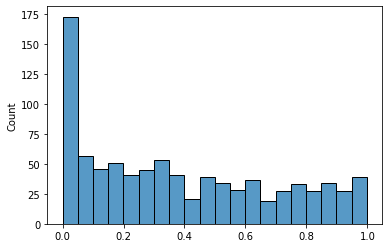

In [197]:
sns.histplot(time_corr_p, bins=20)

In [198]:
pd.Series(time_corr_p[time_corr_p < 0.05]).describe()

count    1.730000e+02
mean     1.788653e-02
std      1.454839e-02
min      1.980444e-09
25%      5.190776e-03
50%      1.614800e-02
75%      2.739933e-02
max      4.980335e-02
dtype: float64

In [199]:
pd.Series(abs(time_corr[time_corr_p < 0.05])).describe()

count    173.000000
mean       0.100687
std        0.022994
min        0.076045
25%        0.085476
50%        0.093185
75%        0.108187
max        0.229786
dtype: float64

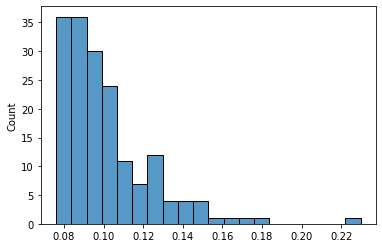

In [216]:
sns.histplot(abs(time_corr[time_corr_p < 0.05]), bins=20)

In [233]:
time_2 = (labeled_train_X['cp_time'] - 2) ** 2
time_2_corr = [stats.pearsonr(labeled_train_X[f], time_2) for f in features_gc]
time_2_corr, time_2_corr_p = zip(*time_2_corr)
time_2_corr = np.asarray(time_2_corr)
time_2_corr_p = np.asarray(time_2_corr_p)

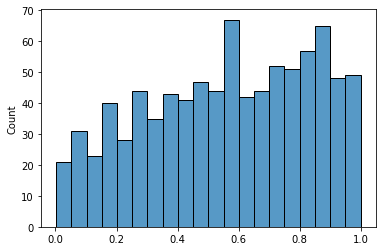

In [234]:
sns.histplot(time_2_corr_p, bins=20)

In [235]:
pd.Series(time_2_corr_p[time_2_corr_p < 0.05]).describe()

count    20.000000
mean      0.022365
std       0.013576
min       0.002203
25%       0.009566
50%       0.023337
75%       0.030514
max       0.049882
dtype: float64

In [236]:
pd.Series(abs(time_2_corr[time_2_corr_p < 0.05])).describe()

count    20.000000
mean      0.091697
std       0.011670
min       0.076019
25%       0.083838
50%       0.087874
75%       0.100339
max       0.118432
dtype: float64

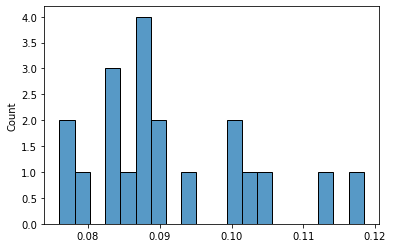

In [237]:
sns.histplot(abs(time_2_corr[time_2_corr_p < 0.05]), bins=20)

In [200]:
dose_corr = [stats.pearsonr(labeled_train_X[f], labeled_train_X['cp_dose']) for f in features_gc]
dose_corr, dose_corr_p = zip(*dose_corr)
dose_corr = np.asarray(dose_corr)
dose_corr_p = np.asarray(dose_corr_p)

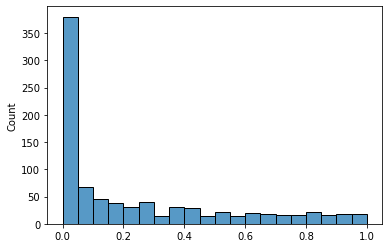

In [201]:
sns.histplot(dose_corr_p, bins=20)

In [202]:
pd.Series(dose_corr_p[dose_corr_p < 0.05]).describe()

count    3.800000e+02
mean     1.185233e-02
std      1.355139e-02
min      5.043667e-17
25%      1.418573e-03
50%      5.732941e-03
75%      1.934299e-02
max      4.963896e-02
dtype: float64

In [203]:
pd.Series(abs(dose_corr[dose_corr_p < 0.05])).describe()

count    380.000000
mean       0.114105
std        0.035530
min        0.076100
25%        0.090613
50%        0.106946
75%        0.123407
max        0.317111
dtype: float64

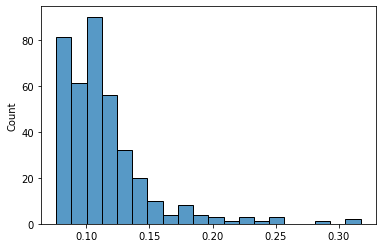

In [217]:
sns.histplot(abs(dose_corr[dose_corr_p < 0.05]), bins=20)

In [238]:
timedose_1 = labeled_train_X['cp_dose'] * labeled_train_X['cp_time']
timedose_1_corr = [stats.pearsonr(labeled_train_X[f], timedose_1) for f in features_gc]
timedose_1_corr, timedose_1_corr_p = zip(*timedose_1_corr)
timedose_1_corr = np.asarray(timedose_1_corr)
timedose_1_corr_p = np.asarray(timedose_1_corr_p)

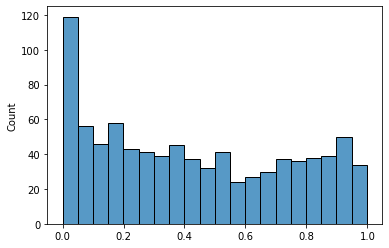

In [239]:
sns.histplot(timedose_1_corr_p, bins=20)

In [240]:
pd.Series(timedose_1_corr_p[timedose_1_corr_p < 0.05]).describe()

count    1.190000e+02
mean     1.548875e-02
std      1.558686e-02
min      1.497232e-10
25%      2.050776e-03
50%      8.805431e-03
75%      2.975468e-02
max      4.970637e-02
dtype: float64

In [241]:
pd.Series(abs(timedose_1_corr[timedose_1_corr_p < 0.05])).describe()

count    119.000000
mean       0.108915
std        0.031567
min        0.076077
25%        0.084225
50%        0.101433
75%        0.119254
max        0.244885
dtype: float64

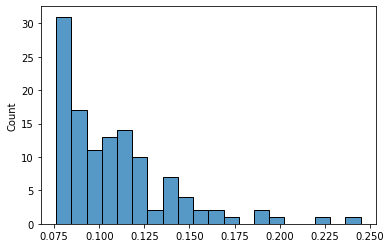

In [242]:
sns.histplot(abs(timedose_1_corr[timedose_1_corr_p < 0.05]), bins=20)

In [243]:
timedose_2 =  labeled_train_X['cp_dose'] / labeled_train_X['cp_time']
timedose_2_corr = [stats.pearsonr(labeled_train_X[f], timedose_2) for f in features_gc]
timedose_2_corr, timedose_2_corr_p = zip(*timedose_2_corr)
timedose_2_corr = np.asarray(timedose_2_corr)
timedose_2_corr_p = np.asarray(timedose_2_corr_p)

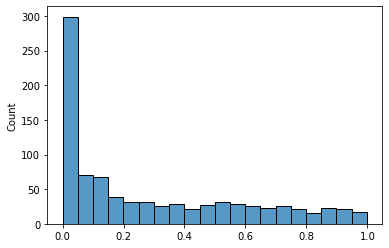

In [244]:
sns.histplot(timedose_2_corr_p, bins=20)

In [245]:
pd.Series(timedose_2_corr_p[timedose_2_corr_p < 0.05]).describe()

count    2.990000e+02
mean     1.273514e-02
std      1.409183e-02
min      1.180012e-10
25%      1.295799e-03
50%      7.238011e-03
75%      1.919441e-02
max      4.988170e-02
dtype: float64

In [246]:
pd.Series(abs(timedose_2_corr[timedose_2_corr_p < 0.05])).describe()

count    299.000000
mean       0.110084
std        0.026872
min        0.076019
25%        0.090724
50%        0.103981
75%        0.124403
max        0.246227
dtype: float64

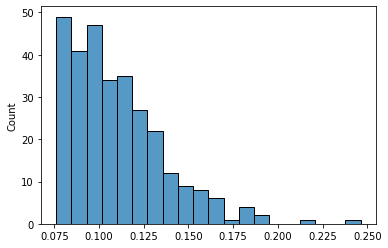

In [247]:
sns.histplot(abs(timedose_2_corr[timedose_2_corr_p < 0.05]), bins=20)

In [273]:
timedose_3 =  labeled_train_X['cp_dose'] - np.sqrt(labeled_train_X['cp_time'])
timedose_3_corr = [stats.pearsonr(labeled_train_X[f], timedose_3) for f in features_gc]
timedose_3_corr, timedose_3_corr_p = zip(*timedose_3_corr)
timedose_3_corr = np.asarray(timedose_3_corr)
timedose_3_corr_p = np.asarray(timedose_3_corr_p)

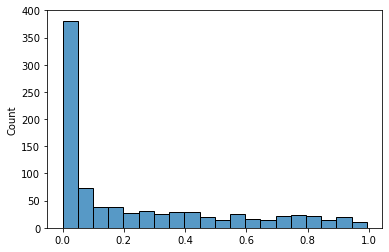

In [274]:
sns.histplot(timedose_3_corr_p, bins=20)

In [275]:
pd.Series(timedose_3_corr_p[timedose_3_corr_p < 0.05]).describe()

count    3.810000e+02
mean     8.844010e-03
std      1.222360e-02
min      1.269802e-15
25%      3.231610e-04
50%      2.919080e-03
75%      1.233945e-02
max      4.967687e-02
dtype: float64

In [276]:
pd.Series(abs(timedose_3_corr[timedose_3_corr_p < 0.05])).describe()

count    381.000000
mean       0.120803
std        0.033341
min        0.076087
25%        0.096915
50%        0.115155
75%        0.138926
max        0.303145
dtype: float64

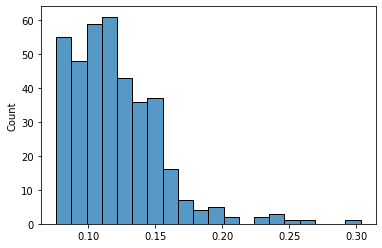

In [277]:
sns.histplot(abs(timedose_3_corr[timedose_3_corr_p < 0.05]), bins=20)

In [3]:
leaderboard = pd.read_csv('lish-moa-publicleaderboard.csv', index_col='TeamId', keep_default_na=False).sort_values('Score')
mask_pzad = leaderboard.TeamName.str.lower().str.contains('pzad')
leaderboard[mask_pzad]

TeamName       SubmissionDate    Score
TeamId                                                               
5469496            Maloyan Narek (PZAD)  2020-10-15 09:12:57  0.01874
5701633              Saenko Ivan (PZAD)  2020-10-22 16:39:45  0.01881
5674266            Iulii Vasiliev(PZAD)  2020-10-18 12:29:01  0.01898
5691382     Alexander Shpitalnik (PZAD)  2020-10-22 16:43:09  0.01900
5697837          Koptelov Dmitry (PZAD)  2020-10-20 23:03:40  0.01964
5713810  Svetlana Kryzhanovskaya (PZAD)  2020-10-23 14:43:14  0.02009
5696843             Daniil Nerus (PZAD)  2020-10-23 10:10:19  0.02014
5713773           Olga Goldobina (PZAD)  2020-10-23 18:21:33  0.02023
5693225              Lebed Fedor (PZAD)  2020-10-22 17:42:53  0.02051
5699633          Korolev Nikolay (PZAD)  2020-10-25 21:52:15  0.02072
5668747           Lukianov Pavel (PZAD)  2020-10-23 07:57:27  0.02091
5669172        Kolmagorov Evgeniy(PZAD)  2020-10-24 09:31:27  0.02325
5713133          NakhodnovMaksim (PZAD)  2020-10-22 20:22:55  0.02329
5708088    Ustyuzhanin Alexander (PZAD)  2020-10-21 19:50:25  0.02398
5711900             Popov Dmitry (PZAD)  2020-10-22 15:21:40  0.02398
5652419     Alexander Chernyshev (PZAD)  2020-10-23 00:32:08  0.02504
5653002         Kormakov Georgiy (PZAD)  2020-10-22 14:18:38  0.02530
5725274      Alexander D'yakonov (PZAD)  2020-10-25 19:41:05  0.02588
5713594        Maltsev Alexander (PZAD)  2020-10-23 20:37:03  0.02656
5688331          Andrey Stotskiy (PZAD)  2020-10-22 21:00:32  0.03496
5694136       Kinazarov Temirbek (PZAD)  2020-10-22 15:42:38  0.05887
5713831              Olga Tyshova(PZAD)  2020-10-24 00:32:30  0.05950
5652362         Milyuta Evgeniya (PZAD)  2020-10-23 06:40:41  0.09547
5712208              Ivan Kobzev (PZAD)  2020-10-24 00:03:29  0.09597
5708836           Shadrin Sergei (PZAD)  2020-10-23 06:28:35  0.18515
5718685           Daria Petrenko (PZAD)  2020-10-23 20:25:50  0.69314
5687518           Vasiliev Roman (PZAD)  2020-10-22 19:40:32  0.69314

In [291]:
features = train_X.columns
targets = train_Y.columns

In [292]:
full_train = pd.merge(train_X, train_Y, left_index=True, right_index=True)
full_train

cp_type  cp_time     g-0     g-1     g-2     g-3     g-4  \
sig_id                                                                       
id_000644bb2       trt_cp      1.0  1.0620  0.5577 -0.2479 -0.6208 -0.1944   
id_000779bfc       trt_cp      3.0  0.0743  0.4087  0.2991  0.0604  1.0190   
id_000a6266a       trt_cp      2.0  0.6280  0.5817  1.5540 -0.0764 -0.0323   
id_0015fd391       trt_cp      2.0 -0.5138 -0.2491 -0.2656  0.5288  4.0620   
id_001626bd3       trt_cp      3.0 -0.3254 -0.4009  0.9700  0.6919  1.4180   
...                   ...      ...     ...     ...     ...     ...     ...   
id_fffb1ceed       trt_cp      1.0  0.1394 -0.0636 -0.1112 -0.5080 -0.4713   
id_fffb70c0c       trt_cp      1.0 -1.3260  0.3478 -0.3743  0.9905 -0.7178   
id_fffc1c3f4  ctl_vehicle      2.0  0.3942  0.3756  0.3109 -0.7389  0.5505   
id_fffcb9e7c       trt_cp      1.0  0.6660  0.2324  0.4392  0.2044  0.8531   
id_ffffdd77b       trt_cp      3.0 -0.8598  1.0240 -0.1361  0.7952 -0.3611   

                 g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12  \
sig_id                                                                         
id_000644bb2 -1.0120 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574   
id_000779bfc  0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958   
id_000a6266a  1.2390  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366   
id_0015fd391 -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511   
id_001626bd3 -0.8244 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed  0.7201  0.5773  0.3055 -0.4726  0.1269  0.2531  0.1730 -0.4532   
id_fffb70c0c  0.6621 -0.2252 -0.5565  0.5112  0.6727 -0.1851  2.8650 -0.2140   
id_fffc1c3f4 -0.0159 -0.2541  0.1745 -0.0340  0.4865 -0.1854  0.0716  0.1729   
id_fffcb9e7c -0.0343  0.0323  0.0463  0.4299 -0.7985  0.5742  0.1421  2.2700   
id_ffffdd77b -3.6750 -1.2420  0.9146  3.0790  1.2460  1.9460  1.4370  2.9780   

                g-13    g-14    g-15    g-16    g-17    g-18    g-19    g-20  \
sig_id                                                                         
id_000644bb2 -0.4015  0.1789 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688   
id_000779bfc  0.4590  0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449   
id_000a6266a -1.8300  0.6057 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799   
id_0015fd391 -0.5844 -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200   
id_001626bd3  1.1750  0.2042  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed -1.0790  0.2474 -0.4550  0.3588  0.1600 -0.7362 -0.1103  0.8550   
id_fffb70c0c -0.6153  0.8362  0.5584 -0.2589  0.1292  0.0148  0.0949 -0.2182   
id_fffc1c3f4 -0.0434  0.1542 -0.2192 -0.0302 -0.4218  0.4057 -0.5372  0.1521   
id_fffcb9e7c  0.2046  0.5363 -1.7330  0.1450  0.6097  0.2024  0.9865 -0.7805   
id_ffffdd77b  2.2370 -0.6818  0.6870 -1.1060  0.0182 -0.9247 -0.0738 -0.1919   

                g-21    g-22    g-23    g-24    g-25    g-26    g-27    g-28  \
sig_id                                                                         
id_000644bb2 -1.1360 -1.1880  0.6940  0.4393  0.2664  0.1907  0.1628 -0.2853   
id_000779bfc -0.1646 -0.2657 -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216   
id_000a6266a -0.8181 -1.5320  0.2307  0.4901  0.4780 -1.3970  4.6240 -0.0437   
id_0015fd391 -1.1580 -0.7191 -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479   
id_001626bd3 -0.2685  0.7649  0.2057  1.3720  0.6835  0.8056 -0.3754 -1.2090   
...              ...     ...     ...     ...     ...     ...     ...     ...   
id_fffb1ceed -0.4139  0.5541  0.2310 -0.5573 -0.4397 -0.9260 -0.2424 -0.6686   
id_fffb70c0c -0.9235  0.0749 -1.5910 -0.8359 -0.9217  0.3013  0.1716  0.0880   
id_fffc1c3f4 -0.2651  0.2310 -0.8101  0.4943  0.6905 -0.3720 -1.4110  0.4516   
id_fffcb9e7c  0.9608  0.3440  2.7650  0.4

In [293]:
train_Y.columns[34]

'atp-sensitive_potassium_channel_antagonist'

In [294]:
full_train.groupby('cp_time')['atp-sensitive_potassium_channel_antagonist'].value_counts()

cp_time  atp-sensitive_potassium_channel_antagonist
1.0      0.0                                           7772
2.0      0.0                                           8249
         1.0                                              1
3.0      0.0                                           7792
Name: atp-sensitive_potassium_channel_antagonist, dtype: int64

In [295]:
train_Y.columns[82]

'erbb2_inhibitor'

In [296]:
full_train.groupby('cp_time')['erbb2_inhibitor'].value_counts()

cp_time  erbb2_inhibitor
1.0      0.0                7772
2.0      0.0                8249
         1.0                   1
3.0      0.0                7792
Name: erbb2_inhibitor, dtype: int64

In [297]:
train_Y = pd.read_csv('../input/lish-moa/train_targets_scored.csv', index_col='sig_id')

In [298]:
train_Y

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
sig_id                                                              
id_000644bb2                            0                       0   
id_000779bfc                            0                       0   
id_000a6266a                            0                       0   
id_0015fd391                            0                       0   
id_001626bd3                            0                       0   
...                                   ...                     ...   
id_fffb1ceed                            0                       0   
id_fffb70c0c                            0                       0   
id_fffc1c3f4                            0                       0   
id_fffcb9e7c                            0                       0   
id_ffffdd77b                            0                       0   

              acat_inhibitor  acetylcholine_receptor_agonist  \
sig_id                                                         
id_000644bb2               0                               0   
id_000779bfc               0                               0   
id_000a6266a               0                               0   
id_0015fd391               0                               0   
id_001626bd3               0                               0   
...                      ...                             ...   
id_fffb1ceed               0                               0   
id_fffb70c0c               0                               0   
id_fffc1c3f4               0                               0   
id_fffcb9e7c               0                               0   
id_ffffdd77b               0                               0   

              acetylcholine_receptor_antagonist  \
sig_id                                            
id_000644bb2                                  0   
id_000779bfc                                  0   
id_000a6266a                                  0   
id_0015fd391                                  0   
id_001626bd3                                  0   
...                                         ...   
id_fffb1ceed                                  0   
id_fffb70c0c                                  0   
id_fffc1c3f4                                  0   
id_fffcb9e7c                                  0   
id_ffffdd77b                                  0   

              acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
sig_id                                                                     
id_000644bb2                               0                           0   
id_000779bfc                               0                           0   
id_000a6266a                               0                           0   
id_0015fd391                               0                           0   
id_001626bd3                               0                           0   
...                                      ...                         ...   
id_fffb1ceed                               0                           0   
id_fffb70c0c                               0                           0   
id_fffc1c3f4                               0                           0   
id_fffcb9e7c                               0                           0   
id_ffffdd77b                               0                           0   

              adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
sig_id                                                                    
id_000644bb2                              0                           0   
id_000779bfc                              0                           0   
id_000a6266a                              0                           0   
id_0015fd391                              0                           0   
id_001626bd3                              0                           0   
...                                     ...                         ...   
id_fffb1ceed                  

In [299]:
drug_to_ids = {}
for sig_id in tqdm(train_Y.index):
    if full_train.loc[sig_id, 'cp_type'] != 'ctl_vehicle':
        drug_to_ids.setdefault(tuple([i for i,v in enumerate(train_Y.loc[sig_id]) if v != 0]), []).append(sig_id)

100%|██████████████████████████████████| 23814/23814 [00:02<00:00, 8730.34it/s]


In [300]:
len(drug_to_ids)

328

In [301]:
len([a for b in drug_to_ids.values() for a in b])

21948

In [302]:
for i in drug_to_ids.values():
    print(len(i))
    break

42


In [303]:
drug_class_sizes = {k:len(v) for k,v in drug_to_ids.items()}

In [304]:
sorted(drug_class_sizes.items(), key=operator.itemgetter(1))[-5:]

[((10,), 335), ((99,), 337), ((71,), 374), ((136, 163), 718), ((), 7501)]

In [306]:
sorted(drug_class_sizes.values())[-5:]

[335, 337, 374, 718, 7501]

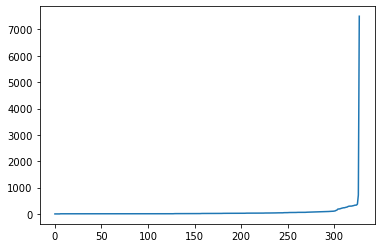

In [307]:
plt.plot(sorted(drug_class_sizes.values()))

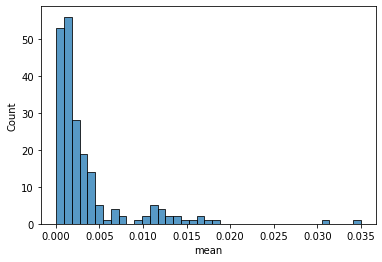

In [308]:
sns.histplot(train_Y.describe().loc['mean'])

In [309]:
train_Y.describe().loc['mean'].sort_values()

atp-sensitive_potassium_channel_antagonist    0.000042
erbb2_inhibitor                               0.000042
diuretic                                      0.000252
autotaxin_inhibitor                           0.000252
protein_phosphatase_inhibitor                 0.000252
                                                ...   
serotonin_receptor_antagonist                 0.016965
dopamine_receptor_antagonist                  0.017805
cyclooxygenase_inhibitor                      0.018267
proteasome_inhibitor                          0.030486
nfkb_inhibitor                                0.034937
Name: mean, Length: 206, dtype: float64

In [310]:
train_Y.describe().loc['mean'].sort_values() * len(train_Y)

atp-sensitive_potassium_channel_antagonist      1.0
erbb2_inhibitor                                 1.0
diuretic                                        6.0
autotaxin_inhibitor                             6.0
protein_phosphatase_inhibitor                   6.0
                                              ...  
serotonin_receptor_antagonist                 404.0
dopamine_receptor_antagonist                  424.0
cyclooxygenase_inhibitor                      435.0
proteasome_inhibitor                          726.0
nfkb_inhibitor                                832.0
Name: mean, Length: 206, dtype: float64

In [205]:
target_corr = train_Y.corr()

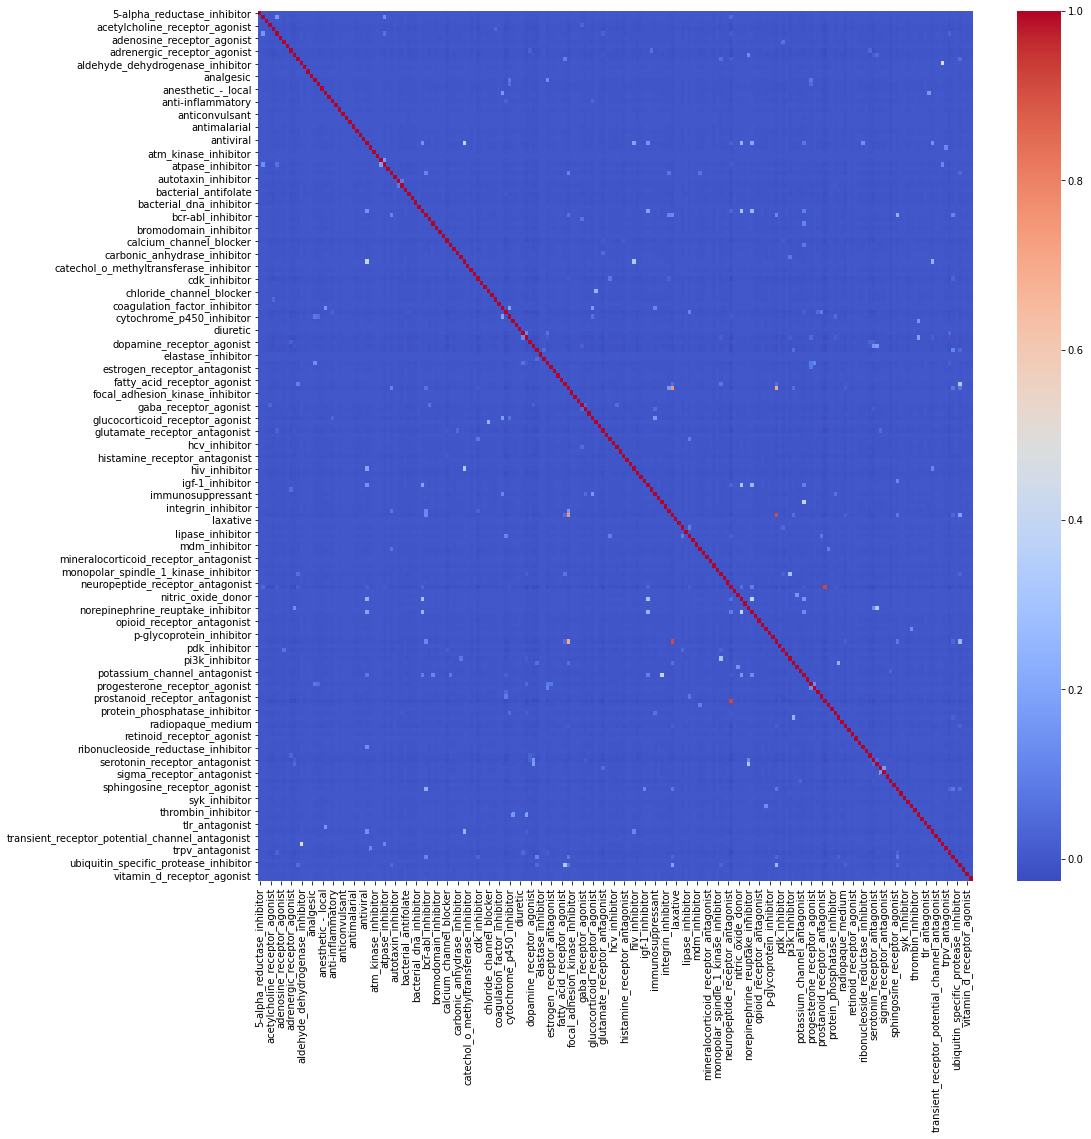

In [187]:
plt.figure(figsize=(16, 16))
sns.heatmap(target_corr, cmap='coolwarm')
plt.show()

In [195]:
tmp = np.asarray(target_corr - np.eye(target_corr.shape[0])).flatten()

In [218]:
for idx in np.argsort(np.abs(tmp))[-20::2]:
    i, j = np.unravel_index(idx, target_corr.shape)
    print(targets[i], train_Y[targets[i]].sum(), targets[j], train_Y[targets[j]].sum(), target_corr.loc[targets[i], targets[j]])

vegfr_inhibitor 170 fgfr_inhibitor 50 0.33391418712541016
norepinephrine_reuptake_inhibitor 7 serotonin_reuptake_inhibitor 44 0.34151056314366374
ppar_receptor_agonist 115 insulin_sensitizer 51 0.4029770379736693
apoptosis_stimulant 49 caspase_activator 18 0.40338145250195234
nitric_oxide_production_inhibitor 12 nrf2_activator 18 0.40788805948901374
aldehyde_dehydrogenase_inhibitor 7 trpv_agonist 25 0.5289501843839842
pdgfr_inhibitor 297 flt3_inhibitor 279 0.7051192026218511
flt3_inhibitor 279 kit_inhibitor 273 0.7581117659978208
kit_inhibitor 273 pdgfr_inhibitor 297 0.9156030237735607
proteasome_inhibitor 726 nfkb_inhibitor 832 0.9213401736871383


In [219]:
feature_corr = train_X.corr()

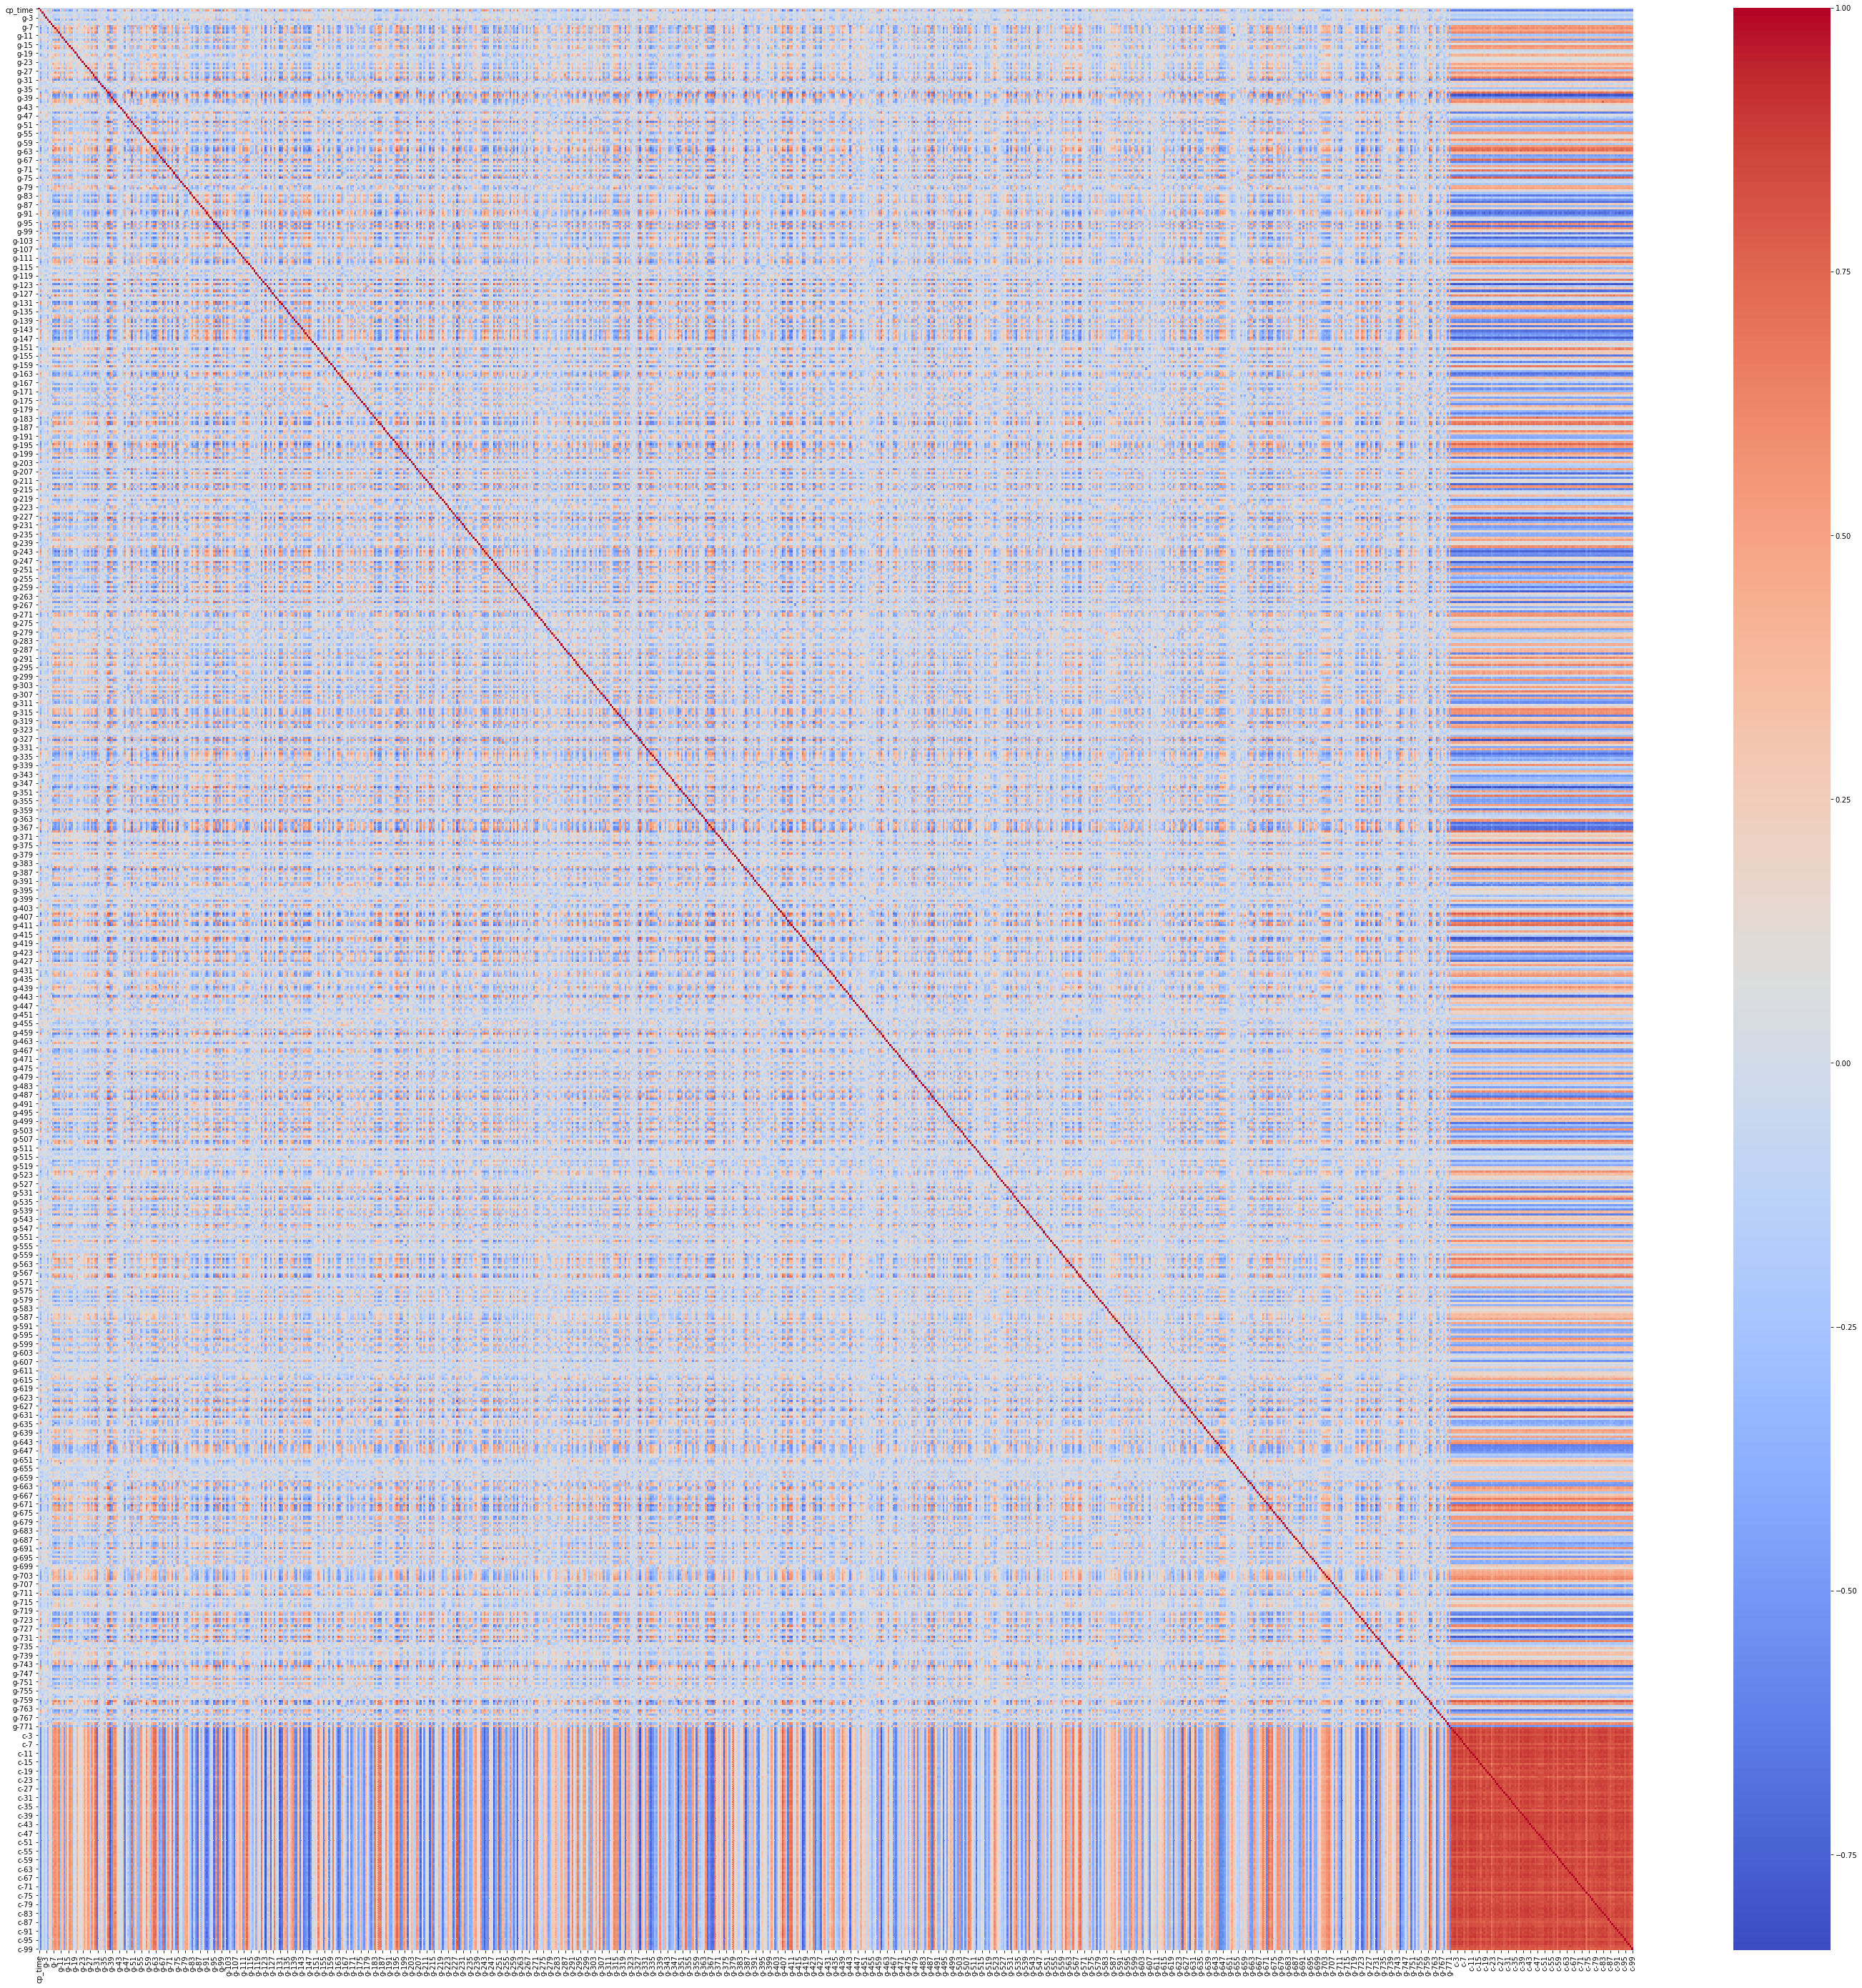

In [220]:
plt.figure(figsize=(50, 50))
sns.heatmap(feature_corr, cmap='coolwarm')
plt.show()

In [221]:
tmp = np.asarray(feature_corr - np.eye(feature_corr.shape[0])).flatten()

In [224]:
for idx in np.argsort(np.abs(tmp))[-20::2]:
    i, j = np.unravel_index(idx, feature_corr.shape)
    print(features[i], features[j], feature_corr.loc[features[i], features[j]])

c-2 c-40 0.9098287358157137
c-2 c-50 0.8487240818600248
c-11 c-92 0.87873331006449
c-92 c-36 0.8664606414968561
c-61 c-36 0.820259827268467
c-53 c-9 0.7735236072832852
c-4 c-31 0.9011485723501768
c-11 c-24 0.8825532738072055
c-11 c-71 0.8496175388284088
c-50 c-40 0.8535743668704855


cp_time  cp_dose
1.0      0          3886
         1          3886
2.0      0          4354
         1          3896
3.0      0          3907
         1          3885
dtype: int64

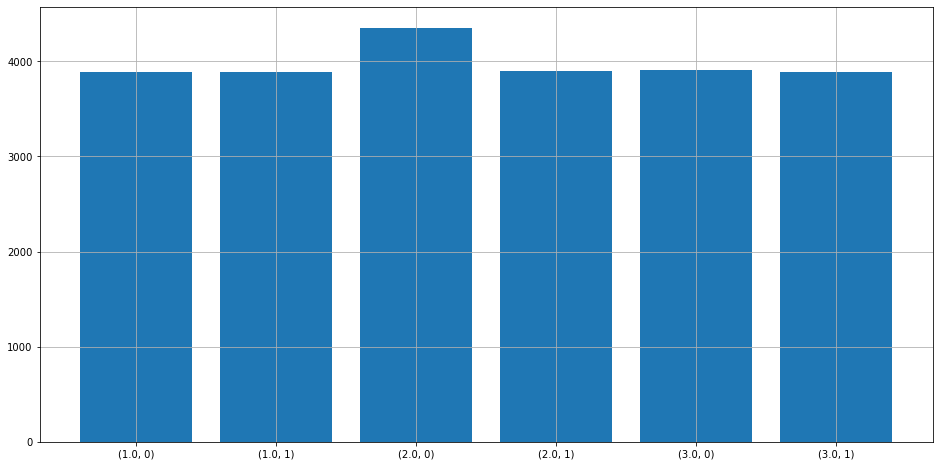

In [316]:
train_X_distr = train_X.groupby(['cp_time', 'cp_dose']).size()
display(train_X_distr)

plt.figure(figsize=(16, 8))
plt.bar(range(6), train_X_distr)
plt.xticks(range(6), train_X_distr.index)
plt.grid()

cp_time  cp_dose
1.0      0          648
         1          652
2.0      0          725
         1          652
3.0      0          654
         1          651
dtype: int64

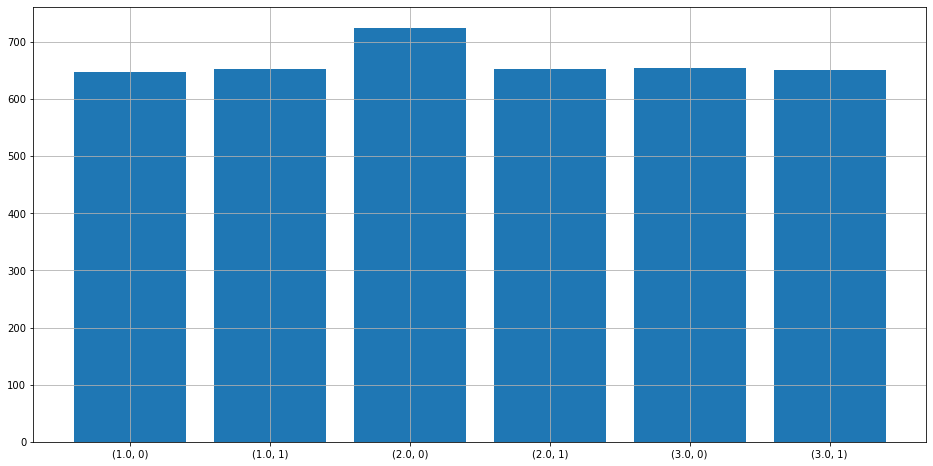

In [317]:
test_X_distr = test_X.groupby(['cp_time', 'cp_dose']).size()
display(test_X_distr)

plt.figure(figsize=(16, 8))
plt.bar(range(6), test_X_distr)
plt.xticks(range(6), test_X_distr.index)
plt.grid()

cp_time  cp_dose
1.0      0          4534
         1          4538
2.0      0          5079
         1          4548
3.0      0          4561
         1          4536
dtype: int64

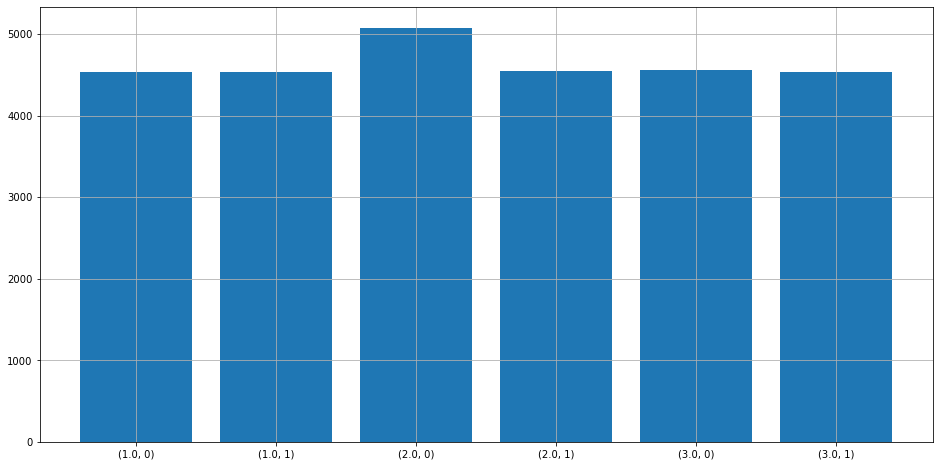

In [318]:
all_X_distr = train_X_distr + test_X_distr
display(all_X_distr)

plt.figure(figsize=(16, 8))
plt.bar(range(6), all_X_distr)
plt.xticks(range(6), all_X_distr.index)
plt.grid()

In [320]:
len(train_X), len(test_X), len(train_X) + len(test_X)

(23814, 3982, 27796)